In [90]:
import numpy as np
import pandas as pd

from patsy import dmatrices, dmatrix
import re
import pickle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

seed = 5
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_json('/Users/laurenfinkelstein/Metis/Projects/Project 3/credit_payment_default/results-20190430-210539.json')

# Data cleaning

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
# is there only one entry per unique user id?
# answer = no duplicates

new = model_data.drop_duplicates()
new.count()
# df_filtered.groupby('id').count()
# df_filtered['id'].value_counts() > 1

In [3]:
# remove unecessary columns and reorder necessary columns

new_columns = ['default_payment_next_month', 'age', 'sex', 'marital_status', 'education_level',  
               'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
               'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
               'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
               'limit_balance']

model_data = df[new_columns]

In [ ]:
model_data.head()

In [ ]:
# figuring out what the different variables mean
# pay_0 etc. have additional labels other than labels described in GCP (e.g., 0, -1), but leave as is?

temp_columns = ['id',  'default_payment_next_month', 'age', 'sex', 'marital_status', 'education_level',  
               'bill_amt_1',
               'pay_0', 
               'pay_amt_1',
               'limit_balance']

df_temp = model_data[temp_columns]
df_temp.head()
# df_temp.pay_0.value_counts()

In [4]:
# where pay_columns have a value < 0, change to 0
# ASSUMPTION: if pay columns have a negative value, customer paid on time

pay_columns = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

for column in pay_columns:
    model_data.loc[model_data[column] < 0, column] = 0

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


# EDA

### Exploring population distributions

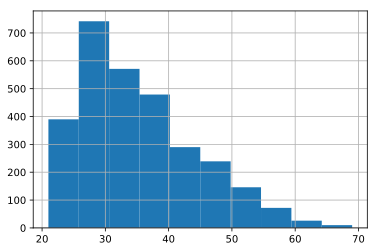

In [36]:
model_data.age.hist()

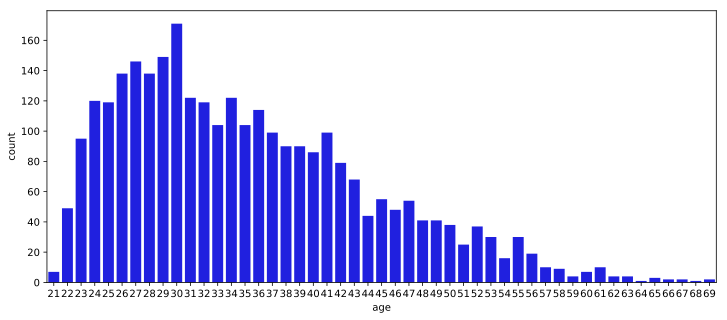

In [5]:
# Distribution of ages of people in the dataset

plt.figure(figsize=(12,5))
sns.countplot(x="age", data=model_data, color='b')

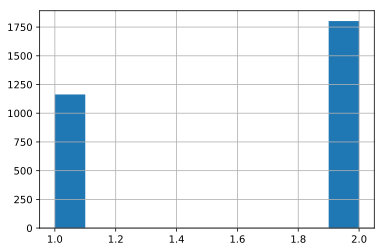

In [37]:
model_data.sex.hist()

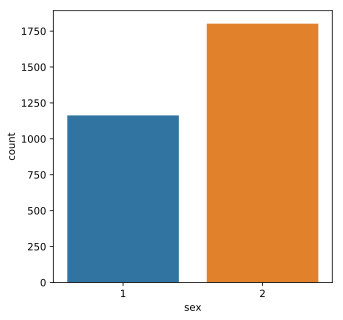

In [6]:
# Distribution of gender of people in the dataset (1=male, 2=female)

plt.figure(figsize=(5,5))
sns.countplot(x="sex", data=model_data)

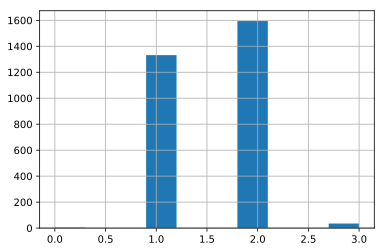

In [38]:
model_data.marital_status.hist()

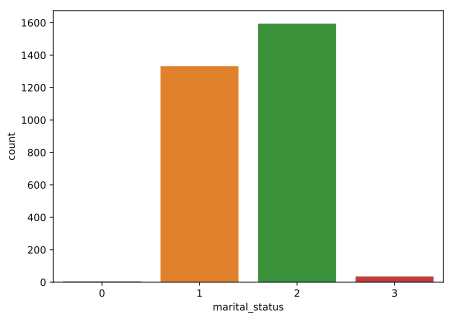

In [7]:
# Distribution of marital status of people in the dataset (1=married, 2=single, 3=other)

plt.figure(figsize=(7,5))
sns.countplot(x="marital_status", data=model_data)

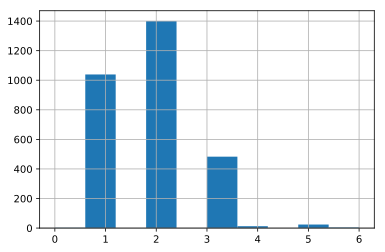

In [39]:
model_data.education_level.hist()

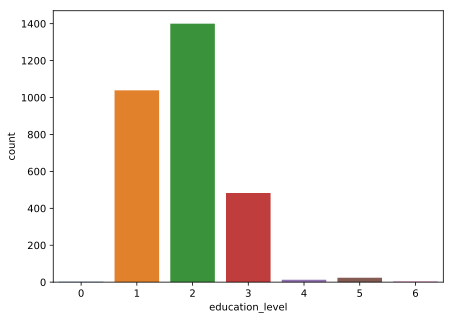

In [8]:
# Distribution of education level of people in the dataset (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

plt.figure(figsize=(7,5))
sns.countplot(x="education_level", data=model_data)

### Exploring bill and payment distributions

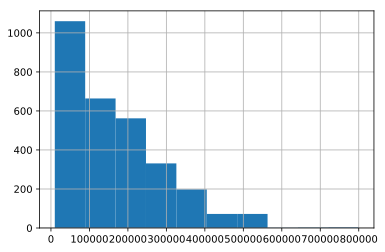

In [78]:
model_data.limit_balance.hist()

In [81]:
# Distribution of credit limit for people in the dataset

plt.figure(figsize=(7,5))
sns.distplot(a="limit_balance", data=model_data)

TypeError: distplot() got an unexpected keyword argument 'data'

<Figure size 504x360 with 0 Axes>

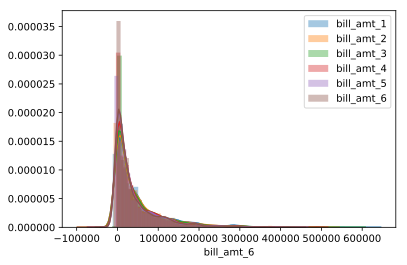

In [9]:
# probability distribution showing bill amounts each month
# shows means and spread

plt.figure(dpi=400)
column_names = ['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6']
sns.distplot(model_data.bill_amt_1)
sns.distplot(model_data.bill_amt_2)
sns.distplot(model_data.bill_amt_3)
sns.distplot(model_data.bill_amt_4)
sns.distplot(model_data.bill_amt_5)
sns.distplot(model_data.bill_amt_6)

plt.legend(column_names)

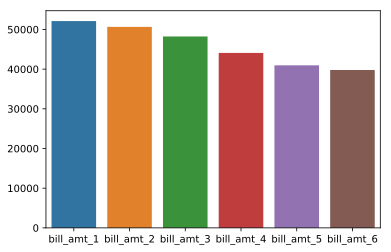

In [10]:
# barplot showing mean bill amounts per month

plt.figure(dpi=400)
bill_amt_columns = ['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6']
bill_amt_means = [model_data.bill_amt_1.mean(), model_data.bill_amt_2.mean(), model_data.bill_amt_3.mean(), model_data.bill_amt_4.mean(), model_data.bill_amt_5.mean(), model_data.bill_amt_6.mean()]
sns.barplot(bill_amt_columns, bill_amt_means)

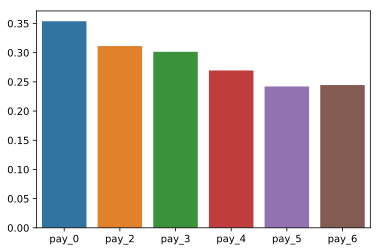

In [11]:
# barplot showing mean pay amounts per month

plt.figure(dpi=400)
pay_columns = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
pay_means = [model_data.pay_0.mean(), model_data.pay_2.mean(), model_data.pay_3.mean(), model_data.pay_4.mean(), model_data.pay_5.mean(), model_data.pay_6.mean()]
sns.barplot(pay_columns,pay_means)

### Exploring variable-to-variable relationships

In [ ]:
# Plot all of the variable-to-variable relationships for bill amounts and pay amounts as scatterplots to visualize correlations all together

bill_pay_amts_columns = ['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
               'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']

df_bill_pay_amts = model_data[bill_pay_amts_columns]

sns.pairplot(df_bill_pay_amts);

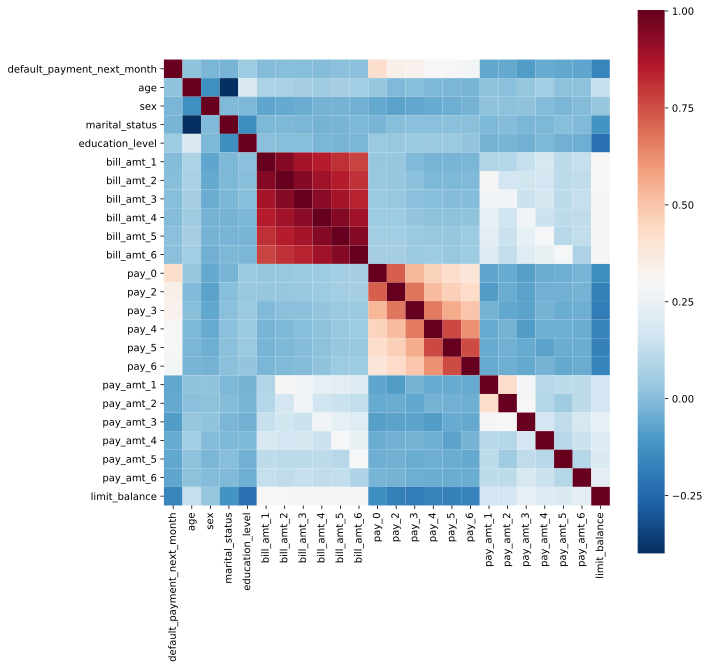

In [12]:
# Plot the correlation matrix
# Note based on my convo with Aaron - this doesn't tell me a lot...

corrs = model_data.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrs, square=True, cmap="RdBu_r");
plt.savefig(fname='corr_matrix', dpi=150)

In [41]:
model_data.corr()

,default_payment_next_month,age,sex,marital_status,education_level,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance
default_payment_next_month,1.000000,0.016905,-0.021765,-0.025998,0.044926,-0.005961,0.000877,-0.001075,-0.004718,0.005930,0.006116,0.420318,0.341508,0.328645,0.304803,0.300786,0.282123,-0.066163,-0.059265,-0.090248,-0.053684,-0.066159,-0.066966,-0.161909
age,0.016905,1.000000,-0.127359,-0.400617,0.197189,0.080546,0.071238,0.063405,0.050337,0.061422,0.057900,0.030823,-0.011496,0.002466,-0.012625,-0.019165,-0.023652,0.016988,0.009628,0.027720,0.058554,0.013403,0.010300,0.130805
sex,-0.021765,-0.127359,1.000000,-0.011742,-0.016816,-0.067615,-0.058139,-0.045150,-0.033684,-0.032004,-0.035632,-0.060180,-0.075948,-0.065967,-0.053170,-0.044255,-0.033151,0.019311,0.014299,0.019432,-0.001635,-0.019963,-0.002479,0.028560
marital_status,-0.025998,-0.400617,-0.011742,1.000000,-0.135548,-0.016926,-0.016148,-0.022133,-0.028957,-0.028412,-0.015740,-0.027740,0.001812,0.004428,0.007931,0.006002,0.005305,-0.017355,-0.006396,-0.019958,-0.017476,-0.000289,-0.008024,-0.117909
education_level,0.044926,0.197189,-0.016816,-0.135548,1.000000,0.008189,0.002172,-0.000919,-0.017839,-0.024139,-0.021942,0.039025,0.032965,0.039846,0.037544,0.039043,0.024559,-0.030440,-0.027683,-0.035931,-0.013496,-0.037795,-0.040558,-0.220874
bill_amt_1,-0.005961,0.080546,-0.067615,-0.016926,0.008189,1.000000,0.942598,0.884206,0.849611,0.811405,0.773977,0.028499,0.031360,-0.010670,-0.024821,-0.024380,-0.018298,0.086527,0.095198,0.135799,0.183517,0.115863,0.134029,0.300388
bill_amt_2,0.000877,0.071238,-0.058139,-0.016148,0.002172,0.942598,1.000000,0.935905,0.892437,0.850391,0.808058,0.034550,0.030380,0.009121,-0.015219,-0.016651,-0.010271,0.305185,0.172737,0.163074,0.171113,0.112100,0.122918,0.301188
bill_amt_3,-0.001075,0.063405,-0.045150,-0.022133,-0.000919,0.884206,0.935905,1.000000,0.929535,0.884765,0.840051,0.037904,0.036095,0.008646,-0.000171,-0.005403,-0.003146,0.274422,0.277097,0.149513,0.174418,0.112649,0.133200,0.305646
bill_amt_4,-0.004718,0.050337,-0.033684,-0.028957,-0.017839,0.849611,0.892437,0.929535,1.000000,0.942601,0.893658,0.047083,0.047145,0.025558,0.014533,0.013699,0.016806,0.235940,0.159537,0.276242,0.147404,0.116938,0.124057,0.308918
bill_amt_5,0.005930,0.061422,-0.032004,-0.028412,-0.024139,0.811405,0.850391,0.884765,0.942601,1.000000,0.941760,0.056517,0.056964,0.038317,0.033745,0.027178,0.043853,0.223636,0.141431,0.239073,0.294002,0.103807,0.126248,0.309346


### Exploring class balance

In [13]:
# target count to determine if classes are imbalanced

target_count = model_data.default_payment_next_month.value_counts()

# print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 2330
Class 1: 635
Proportion: 3.67 : 1
Percentage of Majority Class: 78.58000000000001


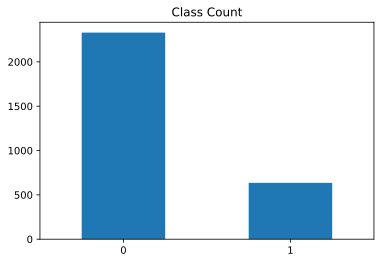

In [14]:
target_count.plot(kind='bar', title='Class Count', rot=0);

# Splitting data into train/test & scaling

In [18]:
# Use Patsy to create my X Matrix
x_cols = ['age', 'sex', 'marital_status', 'education_level',  
        'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
        'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
        'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
         'limit_balance']

# Add interactions
x_str = x_cols[0]
for i in x_cols[1:]:
    x_str = x_str + ' + ' + i
x_str = x_str + '' # if I want to create new variables, add in empty string

x_patsy = dmatrix(x_str, model_data)
x_patsy.shape

(2965, 24)

In [19]:
# Shuffle and then train/test split of my variables
# from sklearn.utils import shuffle

# x_raw = x_patsy
# y_raw = model_data['outcome_var']

#x_shuffle, y_shuffle = shuffle(x_raw, y_raw)
#x_mid, x_test, y_mid, y_test = train_test_split(x_shuffle, y_shuffle, test_size=0.2, random_state=0)
#x_train, x_val, y_train, y_val = train_test_split(x_mid, y_mid, test_size=0.25, random_state=0)

# Stratified train test split
x_raw = x_patsy
y_raw = np.array(model_data['default_payment_next_month'])

sss1 = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
# sss2 = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)

sss1.get_n_splits()
for train_index, test_index in sss1.split(x_raw, y_raw):
    x_train, x_test = x_raw[train_index,:], x_raw[test_index,:]
    y_train, y_test = y_raw[train_index], y_raw[test_index]

# use this later if I want to get fancy...
# sss2.get_n_splits()
# for train_index, test_index in sss2.split(x_mid, y_mid):
#     x_train, x_val = x_mid[train_index,:], x_mid[test_index,:]
#     y_train, y_val = y_mid[train_index], y_mid[test_index]

In [46]:
x_train.shape

(2372, 24)

In [49]:
y_train.shape

(2372,)

In [48]:
x_test.shape

(593, 24)

In [50]:
y_test.shape

(593,)

In [20]:
# Normalize my variables
scaler = StandardScaler()
scaler.fit(x_train)
x_norm_train = scaler.transform(x_train)
# x_norm_val = scaler.transform(x_val)
x_norm_test = scaler.transform(x_test)

# Modeling Round I

- KNN
- Logistic Regression
- SVM
- Linear SVC
- Naive Bayes
- Decision Tree Classifier
- Random Forest
- XGBoost ?
- LightGBM ?
- Neural Net ?

In [15]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### KNN GridSearchCV

In [21]:
# Run CV with 5 folds (knn)

ks = range(1,301,50)
param_grid = [{'n_neighbors': ks}]

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
knn_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    5.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_neighbors': range(1, 301, 50)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [22]:
# this is my best model based on above
# can run .predict(x_test)

knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=201, p=2,
           weights='uniform')

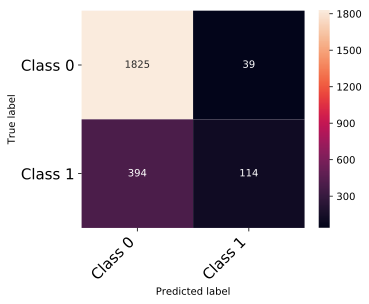

In [57]:
cm = print_confusion_matrix(confusion_matrix(y_train, knn_grid.predict(x_norm_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Logistic Regression GridSearchCV

In [99]:
# Run CV with 5 folds (logit)

penalty = ['l1', 'l2']
C = np.logspace(-3, 1, 100)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='liblinear', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1798s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0647s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 358 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 514 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.09750e-03, ..., 9.11163e+00, 1.00000e+01]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [100]:
# best model for logistic regression (metric = C)

logistic_grid.best_estimator_

LogisticRegression(C=0.02848035868435802, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

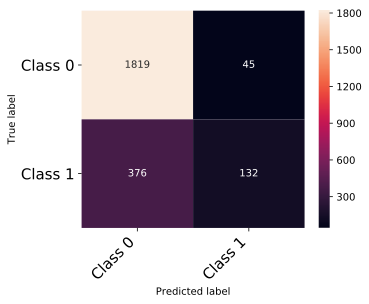

In [58]:
cm = print_confusion_matrix(confusion_matrix(y_train, logistic_grid.predict(x_norm_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

In [ ]:
# print coefficients

logistic = linear_model.LogisticRegression() # ADD PARAMETERS FROM BEST ESTIMATE

# then get coefficients
# those coefficients will tell me which features are most important
# purpose of this is interpretation of what really contributed to my model (presentation)


In [ ]:
# because ROC-AUC scores between logit and RF are so close, can just opt to use logit since it will get rid of features (becuase it chose l1)
# or if I decide to use RF, can then do EDA on features of low importance to inuit which features are important vs. not and why

### SVM GridSearchCV

In [25]:
# Run CV with 5 folds (SVM)

C = np.logspace(-3, 1, 25)
gammas = np.logspace(-3, 0, 25)
param_grid = dict(C=C, gamma=gammas)

svm1 = svm.SVC(kernel='rbf', probability=True)
svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
svm_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.46780e-03, 2.15443e-03, 3.16228e-03, 4.64159e-03,
       6.81292e-03, 1.00000e-02, 1.46780e-02, 2.15443e-02, 3.16228e-02,
       4.64159e-02, 6.81292e-02, 1.00000e-01, 1.46780e-01, 2.15443e-01,
       3.16228e-01, 4.64159e-01, 6.81292e-01, 1.00000e+00, 1.46780e..., 0.07499, 0.1    , 0.13335, 0.17783, 0.23714, 0.31623,
       0.4217 , 0.56234, 0.74989, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [26]:
svm_grid.best_estimator_

SVC(C=0.21544346900318823, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

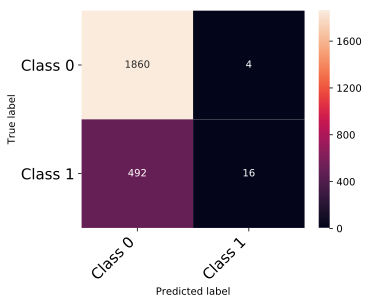

In [59]:
cm = print_confusion_matrix(confusion_matrix(y_train, svm_grid.predict(x_norm_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Linear SVC

IS THE CODE CORRECT?

HOW TO ADD TO ROC/AUC/SCORING?

In [71]:
# Run CV with 5 folds (Linear SVC)

C = np.logspace(-3, 1, 25)
# gammas = np.logspace(-3, 0, 25)
param_grid = dict(C=C)
# param_grid = dict(C=C, gamma=gammas)


# LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#      multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

svc1 = LinearSVC()
svc_grid = GridSearchCV(svc1, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
svc_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1825s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0797s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 105 out of 125 | elapsed:    8.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    9.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.46780e-03, 2.15443e-03, 3.16228e-03, 4.64159e-03,
       6.81292e-03, 1.00000e-02, 1.46780e-02, 2.15443e-02, 3.16228e-02,
       4.64159e-02, 6.81292e-02, 1.00000e-01, 1.46780e-01, 2.15443e-01,
       3.16228e-01, 4.64159e-01, 6.81292e-01, 1.00000e+00, 1.46780e+00,
       2.15443e+00, 3.16228e+00, 4.64159e+00, 6.81292e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [69]:
svc_grid.best_estimator_

LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

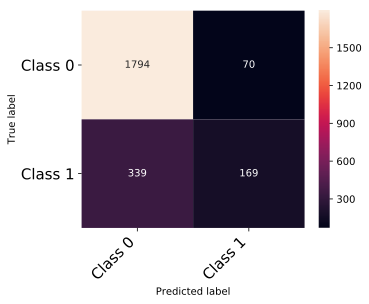

In [70]:
cm = print_confusion_matrix(confusion_matrix(y_train, svc_grid.predict(x_norm_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Naive Bayes Model

In [27]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(x_norm_train, y_train)

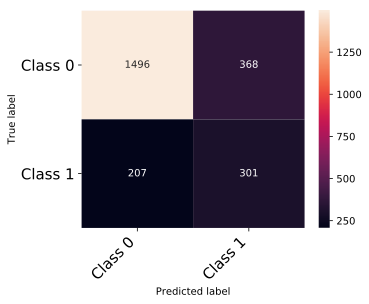

In [60]:
cm = print_confusion_matrix(confusion_matrix(y_train, gnb_best.predict(x_norm_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Decision Tree Classifier GridSearchCV

CORRECT CODE BELOW?

ADD TO ROC-AUC & SCORING

In [74]:
# Run CV with 5 folds (Decision Tree Classifier)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, None],
    'max_features': ['sqrt'], # what is this?
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators': [100, 200, 400, 1000]
}

dectree = DecisionTreeClassifier()
dectree_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
dectree_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [50, 100, None], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 5, 10], 'min_samples_split': [2, 3, 5, 10], 'n_estimators': [100, 200, 400, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [75]:
dectree_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

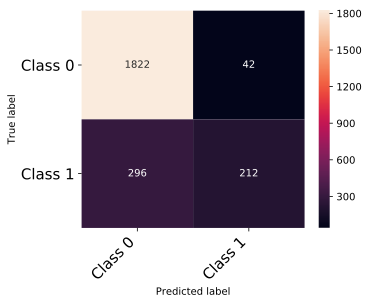

In [77]:
cm = print_confusion_matrix(confusion_matrix(y_train, dectree_grid.predict(x_norm_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Random Forest GridSearchCV

In [28]:
# Run CV with 5 folds (Random Forest)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, None],
    'max_features': ['sqrt'], # what is this?
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators': [100, 200, 400, 1000]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [50, 100, None], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 5, 10], 'min_samples_split': [2, 3, 5, 10], 'n_estimators': [100, 200, 400, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [29]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

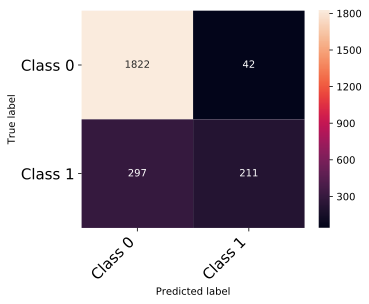

In [61]:
cm = print_confusion_matrix(confusion_matrix(y_train, rf_grid.predict(x_norm_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

In [92]:
# Random Forest Feature Importances

rf2 = RandomForestRegressor(n_estimators=200, max_depth = None)
rf2.fit(x_norm_train, y_train)
rf2.feature_importances_

array([0.        , 0.07697469, 0.01045386, 0.01354276, 0.02061316,
       0.05764463, 0.03840634, 0.04044362, 0.03701509, 0.04087843,
       0.04409379, 0.18790198, 0.01207015, 0.02555069, 0.01124533,
       0.00849168, 0.00974394, 0.04804711, 0.04818703, 0.05453899,
       0.04445082, 0.04628313, 0.06022956, 0.06319322])

In [98]:
# zip each feature importance weight with my columns

pd.DataFrame(zip(list(rf2.feature_importances_), df.columns)) # sort by 0 later

,0,1
0,0.000000,age
1,0.076975,bill_amt_1
2,0.010454,bill_amt_2
3,0.013543,bill_amt_3
4,0.020613,bill_amt_4
5,0.057645,bill_amt_5
6,0.038406,bill_amt_6
7,0.040444,default_payment_next_month
8,0.037015,education_level
9,0.040878,id


### XGBoost

In [ ]:
# run later and do feature importances

### LightGBM

### Neural Net?

### Scoring the models

In [101]:
print('Best ROC_AUC for knn: %0.4f' % knn_grid.best_score_)
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)

Best ROC_AUC for knn: 0.7406
Best ROC_AUC for logit: 0.7592
Best ROC_AUC for svm: 0.7465
Best ROC_AUC for rf: 0.7665


In [ ]:
# score on F1


In [31]:
print('Best Params for knn: ', knn_grid.best_params_)
print('Best Patams for logit: ', logistic_grid.best_params_)
print('Best Params for svm: ', svm_grid.best_params_)
print('Best Params for rf: ', rf_grid.best_params_)

Best Params for knn:  {'n_neighbors': 201}
Best Patams for logit:  {'C': 0.004430621457583882, 'penalty': 'l2'}
Best Params for svm:  {'C': 0.21544346900318823, 'gamma': 0.001}
Best Params for rf:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}


#### NOTE QUESTIONS IN BELOW COMMENTED CODE

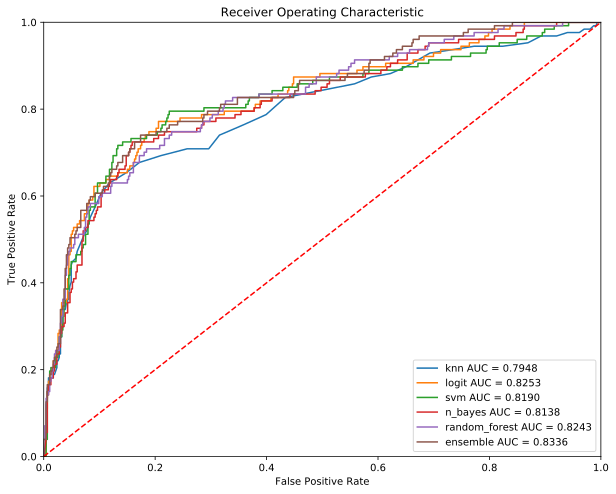

In [34]:
# ROC for all the models

# ARE THE X/Y VARIABLES THE CORRECT ONES TO USE HERE?
# How does the ensembe work?

# How to add new models above into this? E.g., Linear SVC, 

model_list = [knn_grid.best_estimator_, 
              logistic_grid.best_estimator_, 
              svm_grid.best_estimator_, 
              gnb_best, 
              rf_grid.best_estimator_,
              'ensemble']
model_name = ['knn', 'logit', 'svm', 'n_bayes', 'random_forest', 'ensemble']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    if model == 'ensemble':
        w1 = 0.10
        w2 = 0.80
        y_pred = (w1*logistic_grid.best_estimator_.predict_proba(x_norm_test)[:,1] 
                  + w2*rf_grid.best_estimator_.predict_proba(x_norm_test)[:,1]
                  + (1-w1-w2)*gnb_best.predict_proba(x_norm_test)[:,1])
    else:
        y_pred = list(model.predict_proba(x_norm_test)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Run above models with cluster analysis

In [82]:
# Cluster Analysis

from sklearn.cluster import KMeans

cluster_cols = ['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']

# Add interactions
cluster_str = cluster_cols[0]
for i in cluster_cols[1:]:
    cluster_str = cluster_str + ' + ' + i

cluster_patsy = dmatrix(cluster_str, model_data)

cluster_model = KMeans(n_clusters=5)
cluster_model.fit(cluster_patsy)
my_clusters = ['group_' + str(i) for i in cluster_model.labels_]

model_data['my_clusters'] = my_clusters

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
# Use Patsy to create my X Matrix

## QUESTION: need to change variable names to avoid mix up with non clustered variables above?

x_cols = ['my_clusters',
        'age', 'sex', 'marital_status', 'education_level',  
        'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
        'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
        'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
         'limit_balance']
# Add interactions
x_str = x_cols[0]
for i in x_cols[1:]:
    x_str = x_str + ' + ' + i
x_str = x_str + '' # if I want to create new variables, add in empty string

x_patsy = dmatrix(x_str, model_data)
x_patsy.shape

In [84]:
my_clusters[0:30]

['group_0',
 'group_0',
 'group_0',
 'group_0',
 'group_0',
 'group_3',
 'group_4',
 'group_0',
 'group_1',
 'group_0',
 'group_1',
 'group_1',
 'group_0',
 'group_3',
 'group_2',
 'group_0',
 'group_4',
 'group_0',
 'group_3',
 'group_1',
 'group_0',
 'group_0',
 'group_0',
 'group_0',
 'group_0',
 'group_3',
 'group_1',
 'group_0',
 'group_0',
 'group_0']

In [ ]:
# Stratified train test split

# CHANGE VARIABLE NAMES?

x_raw_clusters = x_patsy
y_raw_clusters = np.array(model_data['default_payment_next_month'])

sss1 = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
# sss2 = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)

sss1.get_n_splits()
for train_index, test_index in sss1.split(x_raw, y_raw):
    x_train_clusters, x_test_clusters = x_raw_clusters[train_index,:], x_raw_clusters[test_index,:]
    y_train_clusters, y_test_clusters = y_raw_clusters[train_index], y_raw_clusters[test_index]

# use this later if I want to get fancy...
# sss2.get_n_splits()
# for train_index, test_index in sss2.split(x_mid, y_mid):
#     x_train, x_val = x_mid[train_index,:], x_mid[test_index,:]
#     y_train, y_val = y_mid[train_index], y_mid[test_index]

### KNN GridSearch CV with cluster analysis

In [ ]:
# Run CV with 5 folds (knn)

ks = range(1,301,50)
param_grid = [{'n_neighbors': ks}]

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
knn_grid.fit(x_norm_train, y_train)

In [ ]:
# ROC for all the models

model_list = [knn_grid.best_estimator_, 
              logistic_grid.best_estimator_, 
              svm_grid.best_estimator_, 
              gnb_best, 
              rf_grid.best_estimator_,
              'ensemble',
              dummy]
model_name = ['knn', 'logit', 'svm', 'n_bayes', 'random_forest', 'ensemble', 'dummy']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    if model == 'ensemble':
        w1 = 0.10
        w2 = 0.80
        y_pred = (w1*logistic_grid.best_estimator_.predict_proba(x_norm_val)[:,1] 
                  + w2*rf_grid.best_estimator_.predict_proba(x_norm_val)[:,1]
                  + (1-w1-w2)*gnb_best.predict_proba(x_norm_val)[:,1])
    else:
        y_pred = list(model.predict_proba(x_norm_val)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression GridSearchCV with cluster analysis

### SVM GridSearchCV with Cluster Analysis

### Linear SVC GridSearchCV with Cluster Analysis

### Naive Bayes with Cluster Analysis

### Decision Tree Classifier GridSearchCV with Cluster Analysis

### Random Forest GridSearchCV with Cluster Analysis

### XGBoost ?

### LightGBM ?

### Neural Net ?

# Feature Engineering: marital status and age

# Checking Random Forest Importances

Importances views were created post-modeling to determine possible features to engineer or eliminate, checking if there were overlapping features that were hurting the models since most Random Forest models have high f2 scores and will potentially be chosen as final model for each social media.

# Testing Final Models

# TO DO LATER

In [ ]:
# Note: once I've picked my model, start doing EDA to understand how the top features are contributing to the model (e.g., do married people tend to default less often on their pyaments?)
# do this for the top 10 features for Random Forest or Gradient Boosting Trees (or XGBoost)